# Jason's Notebook

## Restauraunt Data Generation
Much of the restauraunt data set was gathered using the Places API of the Google Maps Platform. To find restauraunts and cafes in the Pittsburgh, points spread at a regular interval within Pittsburgh were sampled using the Place Search feature, which returns a list of relevant listings in a specified radius of the point. To get the points, we needed to represent the area contained within Pittsburgh. This was the source image that was used.

![Pittsburgh Neighborhoods](../datasets/business_list/assets/Pittsburgh_Pennsylvania_neighborhoods.svg)

The SVG file was edited to be a black and white map, with black pixels representating areas inside Pittsburgh.

![Pittsburgh Boundary Map](../datasets/business_list/assets/pittsburgh.png)

Points were generated on a grid, spaced 1 km apart. These were then checked to see if they were within Pittsburgh.

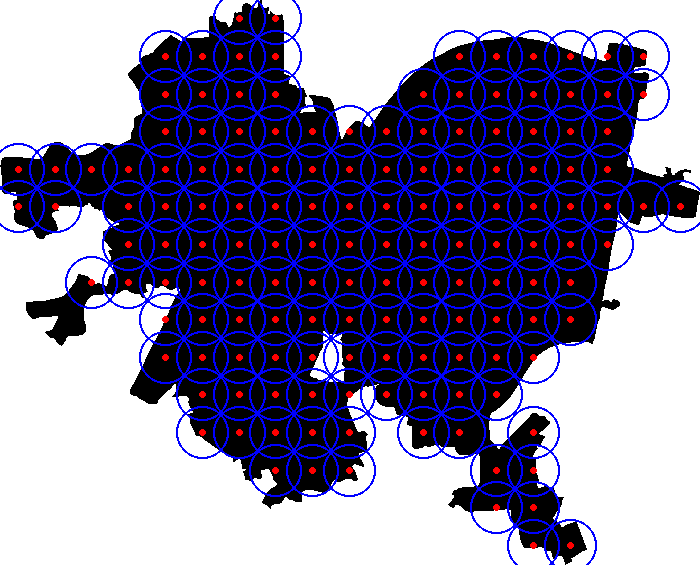

In [2]:
import math
from PIL import Image, ImageDraw

# CONFIG - Search parameters
SPACING = 1

# Geographical information
WEST_EAST_DIST_KM = 19.47 # 85 km per degree longitude
SOUTH_NORTH_DIST_KM = 15.58 # 111 km per degree latitude

# Calculate parameters
RADIUS = SPACING / 2 * math.sqrt(2)
X_INTERVALS = math.floor(WEST_EAST_DIST_KM / SPACING)
X_START = 1 / X_INTERVALS / 2
Y_INTERVALS = math.floor(SOUTH_NORTH_DIST_KM / SPACING)
Y_START = 1 / Y_INTERVALS / 2

RADIUS_PIXELS = math.ceil(RADIUS * map.width / WEST_EAST_DIST_KM)

# Import map
map = Image.open("../datasets/business_list/assets/pittsburgh.png")
map.load()
drawer = ImageDraw.Draw(map)

# Longitude
for x in range(X_INTERVALS):
    x_prop = X_START + x / X_INTERVALS
    pixel_x = math.floor(x_prop * (map.width - 1))

    # Latitude
    for y in range(Y_INTERVALS):
        y_prop = Y_START + y / Y_INTERVALS
        pixel_y = math.floor(y_prop * (map.height - 1))

        # Check intersection
        if (map.getpixel((pixel_x, pixel_y)) == (0, 0, 0, 255)):
            drawer.ellipse((pixel_x - 3, pixel_y - 3, pixel_x + 3, pixel_y + 3), fill="red")
            drawer.ellipse((pixel_x - RADIUS_PIXELS, pixel_y - RADIUS_PIXELS, pixel_x + RADIUS_PIXELS, pixel_y + RADIUS_PIXELS), outline="blue", width=2)

map

If the point was within the boundary (it fell on a black pixel), then it was converted to its corresponding geographical coordinates and used to query the API. The search radius is set to 1.414 km, or sqrt(2) times the spacing to ensure the search covers the entire area. Then, each location returned is queried using Place Details to get more information about each establishment.

In [ ]:
import math, json, time
import googlemaps
from getpass import getpass
from PIL import Image

class API_Session:
    def __init__(self, api_key):
        self.client = googlemaps.Client(key = api_key, timeout=5)
        self.calls = 0

    def call(self, func_name, *args):
        while (True):
            try:
                response = getattr(self, func_name)(*args)
                self.calls += 1
                
                if (response["status"] == "OK"):
                    return response
                else:
                    print("Request error. Status: " + response["status"])
                    input("Press enter to retry.")
            except:
                input("Request failed. Press enter to retry.")

    def first_page(self, latitude, longitude, search_radius, types):
        return self.client.places(location=(latitude, longitude), radius=search_radius, type=types)

    def next_page(self, token):
        return self.client.places(page_token=token)

    def place_details(self, id):
        return self.client.place(place_id=id)

    def get_pages(self, latitude, longitude, search_radius, type, id_list):
        pages = []

        # First page
        page1 = self.call("first_page", latitude, longitude, search_radius, type)
        current_page = page1
        pages.append(page1["results"])

        # Additional pages
        while True:
            token = current_page.get("next_page_token")

            if self.duplicate_count(id_list, current_page["results"]) == 20 or token == None:
                break
            
            time.sleep(2)

            current_page = self.call("next_page", token)
            pages.append(current_page["results"])
        
        return pages

    def duplicate_count(self, id_list, page):
        count = 0
        
        for business in page:
            place_id = business["place_id"]

            if place_id in id_list:
                count += 1
            else:
                id_list.append(place_id)

        return count

# CONFIG - Search parameters
SPACING = 1
TYPES = ["restaurant", "cafe"]

# Geographical information
SOUTH_LIMIT = 40.361370
WEST_LIMIT = -80.095286
NORTH_LIMIT = 40.500925
EAST_LIMIT = -79.865750
WEST_EAST_DIST_DEG = EAST_LIMIT - WEST_LIMIT
WEST_EAST_DIST_KM = 19.47 # 85 km per degree longitude
SOUTH_NORTH_DIST_DEG = NORTH_LIMIT - SOUTH_LIMIT
SOUTH_NORTH_DIST_KM = 15.58 # 111 km per degree latitude

# Calculate parameters
RADIUS = SPACING / 2 * math.sqrt(2)
RADIUS_M = SPACING * 1000
X_INTERVALS = math.floor(WEST_EAST_DIST_KM / SPACING)
X_START = 1 / X_INTERVALS / 2
Y_INTERVALS = math.floor(SOUTH_NORTH_DIST_KM / SPACING)
Y_START = 1 / Y_INTERVALS / 2

# Connect to Google Maps API
api_key = getpass("Enter the API key: ")
api_session = API_Session(api_key)

# PLACE SEARCH
# Import map
map = Image.open("../datasets/business_list/assets/pittsburgh.png")
map.load()

# Query places list from API
output = []
id_list = []

# Longitude
for x in range(X_INTERVALS):
    x_prop = X_START + x / X_INTERVALS
    pixel_x = math.floor(x_prop * (map.width - 1))
    longitude = WEST_LIMIT + x_prop * WEST_EAST_DIST_DEG

    # Latitude
    for y in range(Y_INTERVALS):
        y_prop = Y_START + y / Y_INTERVALS
        pixel_y = math.floor(y_prop * (map.height - 1))
        latitude = NORTH_LIMIT - y_prop * SOUTH_NORTH_DIST_DEG

        # Check intersection
        if (map.getpixel((pixel_x, pixel_y)) == (0, 0, 0, 255)):
            for type in TYPES:
                pages = api_session.get_pages(latitude, longitude, RADIUS_M, type, id_list)

                for page in pages:
                    output.append(page)

# Dump search nearby results
with open("../datasets/business_list/dumps/search_nearby_unprocessed.json", "w", encoding="utf-8-sig") as dump:
    json.dump(output, dump)

# PLACE DETAILS
# Query place details from API
output = []

for place_id in id_list:
    response = api_session.call("place_details", place_id)
    output.append(response["result"])

# Dump search nearby results
with open("../datasets/business_list/dumps/place_details_unprocessed.json", "w", encoding="utf-8-sig") as dump:
    json.dump(output, dump)

# Finish
print("Found " + str(len(id_list)) + " businesses with " + str(api_session.calls) + " API calls")

The output the Place Search and Place Detail queries were dumped into a JSON file to retain all of the information. The Place Details results included the establishment's neighborhood, geographical coordinates, reviews, and opening hours, among other information. This was used to create the business dataset. Only relevant information is extracted and exported to a CSV format, which is more workable. Defunct businesses and businesses not located in Pittsburgh were filtered out the data.

In [1]:
import json, csv

# import json
with open("../datasets/business_list/dumps/place_details_unprocessed.json", "r", encoding="utf-8-sig", newline="") as file:
    place_details = json.load(file)

# import neighborhood list
with open("../datasets/business_list/assets/neighborhood_list.txt", "r") as file:
    neighborhood_list = [name.replace("\n", "") for name in file]

# write to csv
def get_info(business):
    business_status = business.get("business_status")

    # Address components
    address_components = business.get("address_components")
    street_number = None; route = None; neighborhood = None

    for component in address_components:
        level = component["types"][0]

        if level == "street_number":
            street_number = component.get("long_name")
        elif level == "route":
            route = component.get("long_name")
        elif level == "neighborhood":
            neighborhood = component.get("long_name")
        elif level == "postal_code":
            postal_code = component.get("long_name")

    # Filter
    if business_status != "OPERATIONAL" or neighborhood == "" or neighborhood not in neighborhood_list:
        return

    place_id = business.get("place_id")
    name = business.get("name")

    location = business.get("geometry")["location"]
    latitude = location["lat"]
    longitude = location["lng"]

    formatted_address = business.get("formatted_address")

    curbside_pickup = business.get("curbside_pickup")
    price_level = business.get("price_level")
    rating = business.get("rating")
    user_ratings_total = business.get("user_ratings_total")

    # Opening hours
    opening_hours = business.get("opening_hours")
    sun_open = None; sun_close = None; mon_open = None; mon_close = None; tue_open = None; tue_close = None; wed_open = None; wed_close = None; thu_open = None; thu_close = None; fri_open = None; fri_close = None; sat_open = None; sat_close = None

    if (opening_hours != None):
        for day in opening_hours.get("periods"):
            open = day.get("open")
            close = day.get("close") or {}
            day_of_week = open.get("day")

            if day_of_week == 0:
                sun_open = open.get("time")
                sun_close = close.get("time")
            elif day_of_week == 1:
                mon_open = open.get("time")
                mon_close = close.get("time")
            elif day_of_week == 2:
                tue_open = open.get("time")
                tue_close = close.get("time")
            elif day_of_week == 3:
                wed_open = open.get("time")
                wed_close = close.get("time")
            elif day_of_week == 4:
                thu_open = open.get("time")
                thu_close = close.get("time")
            elif day_of_week == 5:
                fri_open = open.get("time")
                fri_close = close.get("time")
            elif day_of_week == 6:
                sat_open = open.get("time")
                sat_close = close.get("time")

    output.append([place_id, name, latitude, longitude, formatted_address, street_number, route, neighborhood, postal_code, curbside_pickup, price_level, rating, user_ratings_total, sun_open, sun_close, mon_open, mon_close, tue_open, tue_close, wed_open, wed_close, thu_open, thu_close, fri_open, fri_close, sat_open, sat_close])

output = []

# csv
with open("../datasets/business_list/business_list.csv", "w", encoding="utf-8-sig", newline='') as csv_out:
    csv_writer = csv.writer(csv_out)
    csv_writer.writerow(["place_id", "name", "latitude", "longitude", "formatted_address", "street_number", "route", "neighborhood", "postal_code", "curbside_pickup", "price_level", "rating", "user_ratings_total", "sun_open", "sun_close", "mon_open", "mon_close", "tue_open", "tue_close", "wed_open", "wed_close", "thu_open", "thu_close", "fri_open", "fri_close", "sat_open", "sat_close"])

    for business in place_details:
        get_info(business)

    csv_writer.writerows(output)

In [28]:
import pandas

business_list = pandas.read_csv("../datasets/business_list/business_list.csv")
business_list.head()

,place_id,name,latitude,longitude,formatted_address,street_number,route,neighborhood,postal_code,curbside_pickup,...,tue_open,tue_close,wed_open,wed_close,thu_open,thu_close,fri_open,fri_close,sat_open,sat_close
0,ChIJhYJfjL31NIgR3phOvhgBNEs,DBO's,40.453212,-80.053709,"635 Hillsboro St, Pittsburgh, PA 15204, USA",635,Hillsboro Street,Sheraden,15204,NaN,...,1200.0,1800.0,1200.0,1800.0,1200.0,1800.0,1200.0,1800.0,1000.0,1500.0
1,ChIJb1vGv1_2NIgRTz6RVpyC9Do,Angkor Restaurant,40.427114,-80.056253,"2350 Noblestown Rd # 18, Pittsburgh, PA 15205,...",2350,Noblestown Road,Oakwood,15205,NaN,...,1130.0,2100.0,1130.0,2100.0,1130.0,2100.0,1130.0,2100.0,1130.0,2100.0
2,ChIJb1vGv1_2NIgRHMolqSfzEd4,Blinky's Noble Grill & Bar,40.427656,-80.055185,"2350 Noblestown Rd # 11, Pittsburgh, PA 15205,...",2350,Noblestown Road,Oakwood,15205,False,...,1100.0,200.0,1100.0,200.0,1100.0,200.0,1100.0,200.0,1100.0,200.0
3,ChIJX9Zv-Zz2NIgRuL5tXjwo8mU,Lorenz Cafe,40.444769,-80.039711,"718 Lorenz Ave, Pittsburgh, PA 15220, USA",718,Lorenz Avenue,Elliott,15220,False,...,1200.0,2000.0,1200.0,2200.0,1200.0,2200.0,1200.0,2300.0,1200.0,2300.0
4,ChIJPUHlkVH3NIgRMwVmDx22dPM,NakaEndZone BBQ,40.438080,-80.054655,"1310 Crafton Blvd, Pittsburgh, PA 15205, USA",1310,Crafton Boulevard,Crafton Heights,15205,True,...,NaN,NaN,1200.0,1900.0,1200.0,1900.0,1200.0,1900.0,1200.0,1900.0


# Fire and Police Incident Data

A higher number of nearby incidents indicates that an area is more dangerous, and therefore detrimental to the dining experience. For the safety and therefore best dining experience, the neighborhood needs to have a low number. 

For each business, the number of nearby incidents is determined, in this case a 1 km radius. The rationale for calculating this for each business and  aggregating the data afterwards instead of simply counting the incidents in each neighborhood using a reverse geocoding is to provide more localized results. This is more accurate as it takes into account the fact that fires may be more common in certain parts of a neighborhood and that fires don't care about neighborhood boundaries.

The same code below is used for both fire and police incidents, with different parameters passed in.

In [308]:
import math, csv

# Geographical information
KM_PER_LONGITUDE = 84.82    
KM_PER_LATITUDE = 111.64

# Calculate distance
def km_distance(lat1, lng1, lat2, lng2):
    x_dist = (lng2 - lng1) * KM_PER_LONGITUDE
    y_dist = (lat2 - lat1) * KM_PER_LATITUDE

    return math.sqrt(x_dist ** 2 + y_dist ** 2)

# Calculate incidents within radius of business
def incident_count(incidents, lat, lng, radius, lat_attr, lng_attr):
    count = 0

    for incident in incidents:
        lat2 = incident.get(lat_attr)
        lng2 = incident.get(lng_attr)

        if lng2 != "":
            if km_distance(lat, lng, float(lat2), float(lng2)) <= radius:
                count += 1
    
    return count

def get_nearby_incidents(business_list_path, incident_list_path, radius, lat_attr, lng_attr):
    output = []
    
    # Open data files
    with open(business_list_path, "r", encoding="utf-8-sig") as business_data:
        with open(incident_list_path, "r") as incident_data:
            business_list = csv.DictReader(business_data)
            incidents = [incident for incident in csv.DictReader(incident_data)]

            # For each business
            for business in business_list:
                place_id = business["place_id"]
                neighborhood = business["neighborhood"]
                lng = float(business["longitude"])
                lat = float(business["latitude"])
                count = incident_count(incidents, lat, lng, radius, lat_attr, lng_attr)
                    
                output.append([place_id, neighborhood, count])
    
    return output

This is the code for generating the choropleth maps using Geopandas. Because Geopandas does not import additional properties on the geometry, like the neighborhood, this has to be manually read in from the geojson file and appended to the GeoDataFrame. A few string replacements were necesssary to match up the neighborhood names from Google Maps and the geojson file.

In [ ]:
import json
import pandas, geopandas
import matplotlib.pyplot as pyplot

%matplotlib inline

def generate_map(incident_list):
    # Load data
    map = geopandas.read_file("../util/Neighborhoods_.geojson")

    # Add neighborhood and count column to GeoDataFrame
    neighborhoods = []

    # Get all neighborhoods names from geojson file
    with open("../util/Neighborhoods_.geojson", "r") as geojson_data:
        data = json.load(geojson_data)
        features = data["features"]

        for feature in features:
            region_name = feature["properties"]["hood"]
            neighborhoods.append(region_name)

    # Correct name variations
    geojson_alias = {
        "Downtown": "Central Business District",
        "Uptown": "Bluff",
        "Allegheny-West": "Allegheny West",
        "Lawrenceville": "Upper Lawrenceville"
    }

    incidents_corrected = incident_list.replace(geojson_alias).groupby("neighborhood").mean(numeric_only=True)

    # Combine dataframes
    incidents_append = pandas.DataFrame(neighborhoods, columns=["neighborhood"])
    incidents_append = incidents_append.merge(incidents_corrected, on="neighborhood", how="outer")
    map["neighborhood"] = incidents_append["neighborhood"]
    map["count"] = incidents_append["count"]

    return map

## Nearby Fire Incidents

Hot food is good, but hot buildings are not. A lower number of nearby fire incidents means there is lower the risk of the building catching on fire and posing a risk to customers.

In [458]:
import pandas

# CONFIG
RADIUS = 1

output = get_nearby_incidents("../datasets/business_list/business_list.csv", "../datasets/fire_incidents/assets/fire_incidents.csv", RADIUS, "latitude", "longitude")
fire_incidents = pandas.DataFrame(output, columns=["place_id", "neighborhood", "count"])
fire_incidents.head()

,place_id,neighborhood,count
0,ChIJhYJfjL31NIgR3phOvhgBNEs,Sheraden,210
1,ChIJb1vGv1_2NIgRTz6RVpyC9Do,Oakwood,32
2,ChIJb1vGv1_2NIgRHMolqSfzEd4,Oakwood,35
3,ChIJX9Zv-Zz2NIgRuL5tXjwo8mU,Elliott,97
4,ChIJPUHlkVH3NIgRMwVmDx22dPM,Crafton Heights,67


Below are the nearby fire incidents for each restauraunt, grouped by neighborhood and averaged.

In [459]:
from matplotlib import style
import matplotlib.pyplot as pyplot

style.use("seaborn-v0_8-bright")
pyplot.rc("axes", titlesize=24, labelsize=22)
pyplot.rc("xtick", labelsize=18)
pyplot.rc("ytick", labelsize=20)

Text(0, 0.5, 'Neighborhood')

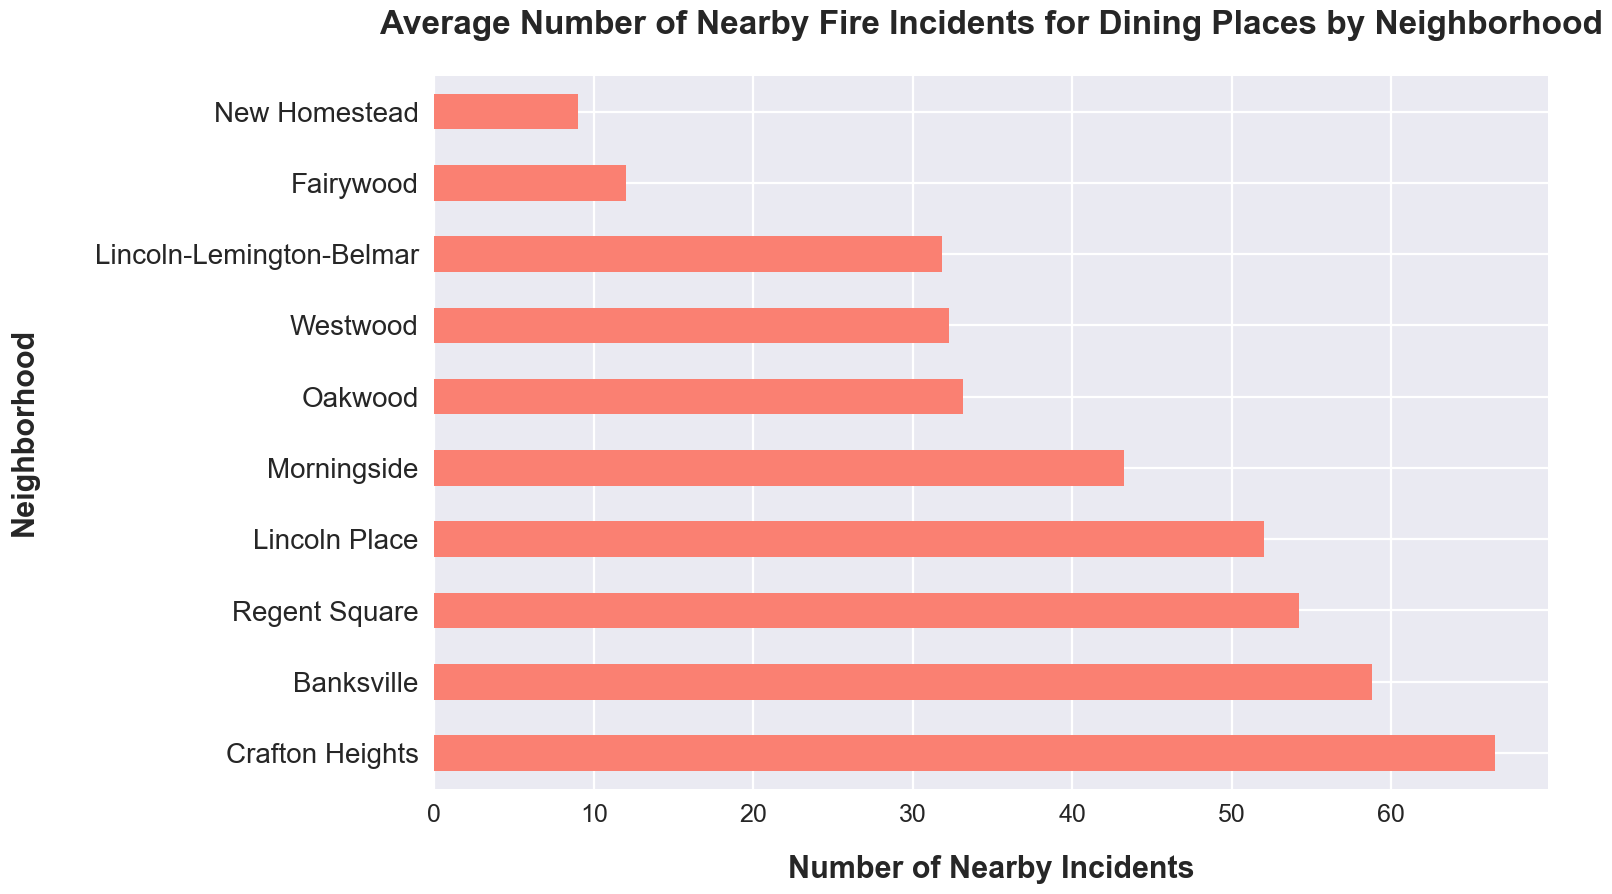

In [460]:
fire_incidents_grouped = fire_incidents.groupby("neighborhood").mean(numeric_only=True).sort_values("count", ascending=False)
fire_incidents_grouped.tail(10).plot.barh(legend=False, color="salmon")
pyplot.title("Average Number of Nearby Fire Incidents for Dining Places by Neighborhood", pad=30, fontweight="bold")
pyplot.xlabel("Number of Nearby Incidents", labelpad=20, fontweight="bold")
pyplot.ylabel("Neighborhood", labelpad=40, fontweight="bold")

Here is the same data visualized in a choropleth graph. The grey regions are neighborhoods with no dining places.

(-80.10681505991924, -79.85429464126216, 40.354642646539126, 40.50793371245118)

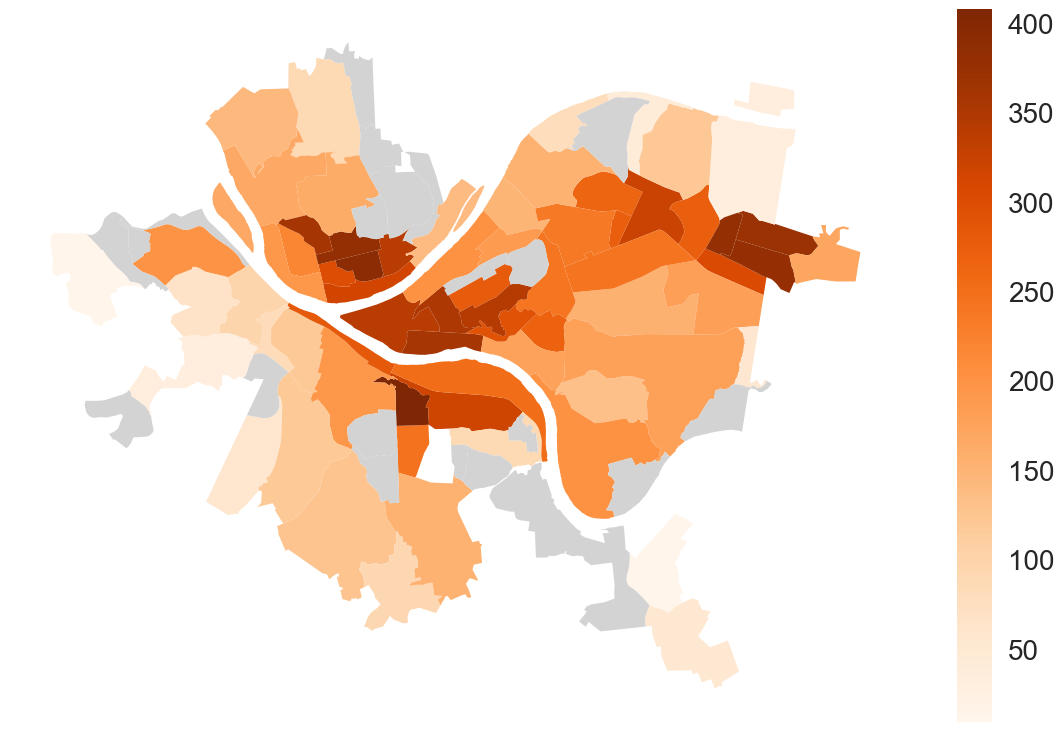

In [462]:
map = generate_map(fire_incidents)

# Display map
map.plot(column="count", legend=True, cmap="Oranges", missing_kwds={"color": "lightgrey"})
pyplot.axis("off")

# Nearby Police Incidents

Nearby police incidents are an indicator of the risk of direct and indirect harm to a customer. Because of this broad interpretation, all types of incidents are included in the analysis. A hit and run of a parked vehicle may not physically hurt a person, but it would sure hurt their dining experience if they were to learn that their car was damaged.

The same process used to analyze the fire incidents is applied to police incidents. Again, a lower number is better.

In [463]:
import pandas

# CONFIG
RADIUS = 1

output = get_nearby_incidents("../datasets/business_list/business_list.csv", "../datasets/police_incidents/assets/police_incidents.csv", RADIUS, "Y", "X")
police_incidents = pandas.DataFrame(output, columns=["place_id", "neighborhood", "count"])
police_incidents.head()

,place_id,neighborhood,count
0,ChIJhYJfjL31NIgR3phOvhgBNEs,Sheraden,64
1,ChIJb1vGv1_2NIgRTz6RVpyC9Do,Oakwood,5
2,ChIJb1vGv1_2NIgRHMolqSfzEd4,Oakwood,7
3,ChIJX9Zv-Zz2NIgRuL5tXjwo8mU,Elliott,26
4,ChIJPUHlkVH3NIgRMwVmDx22dPM,Crafton Heights,27


Below are the average nearby police incidents for the restauraunts in each neighborhood.

Text(0, 0.5, 'Neighborhood')

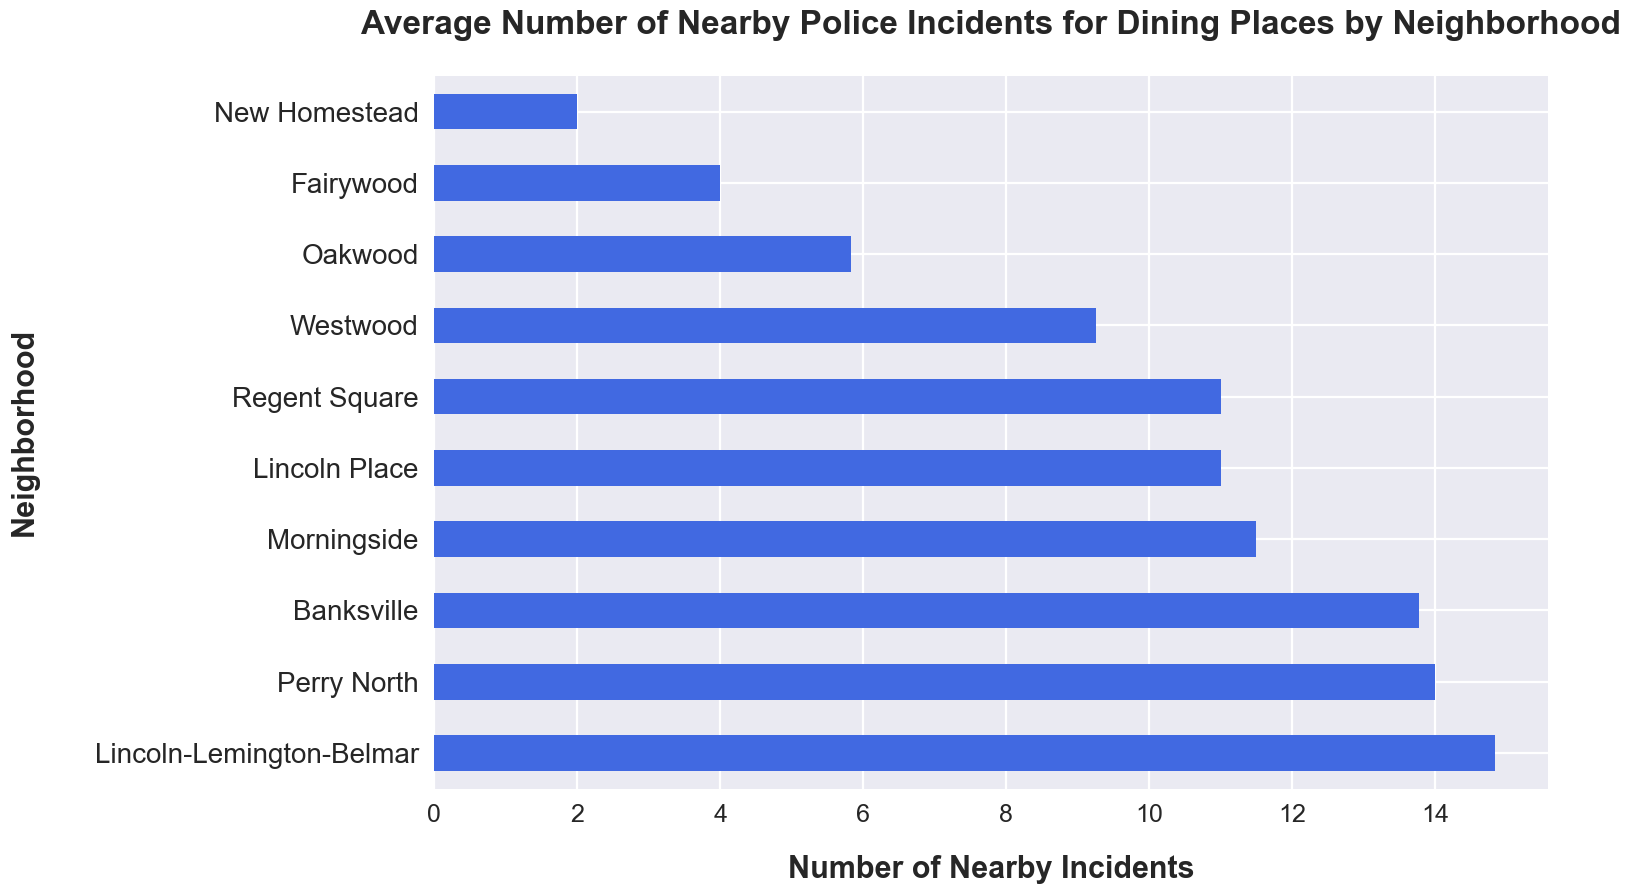

In [464]:
police_incidents_grouped = police_incidents.groupby("neighborhood").mean(numeric_only=True).sort_values("count", ascending=False)
police_incidents_grouped.tail(10).plot.barh(legend=False, color="royalblue")
pyplot.title("Average Number of Nearby Police Incidents for Dining Places by Neighborhood", pad=30, fontweight="bold")
pyplot.xlabel("Number of Nearby Incidents", labelpad=20, fontweight="bold")
pyplot.ylabel("Neighborhood", labelpad=40, fontweight="bold")

(-80.10681505991924, -79.85429464126216, 40.354642646539126, 40.50793371245118)

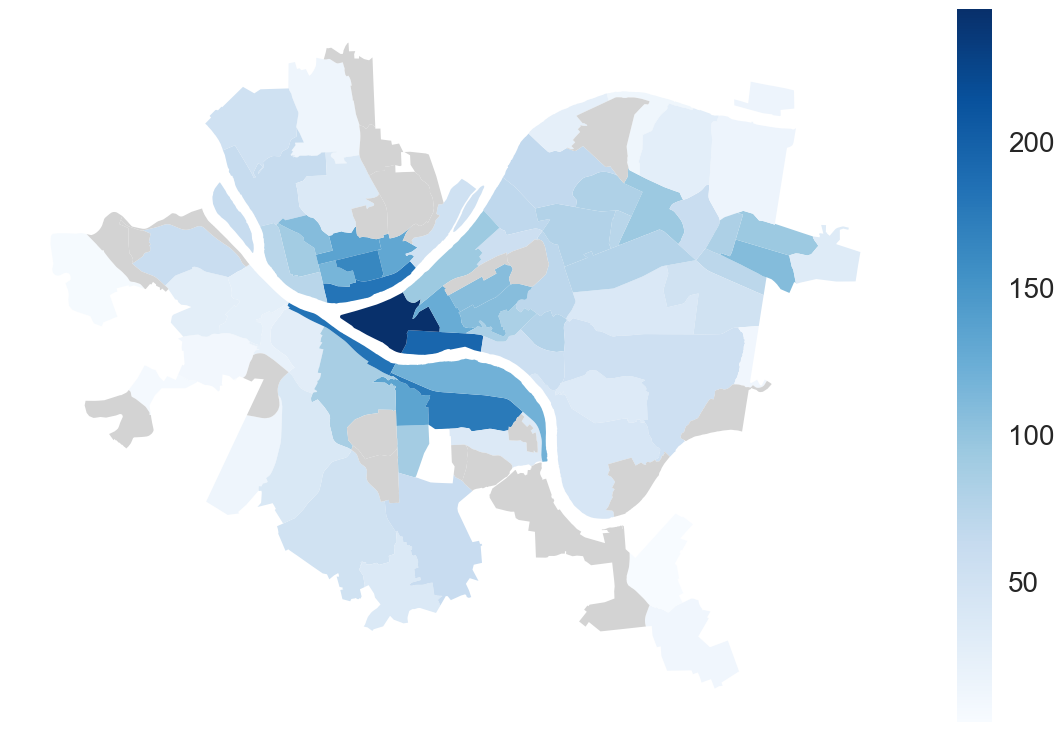

In [465]:
map = generate_map(police_incidents)

# Display map
map.plot(column="count", legend=True, cmap="Blues", missing_kwds={"color": "lightgrey"})
pyplot.axis("off")

# Conclusion

In both submetrics, New Homestead takes the lead with the lowest values, indicating that it is the safest neighborhood to dine in. Fires and crimes are least likely to occur near dining places in New Homestead. I expected the least busy neighborhoods, which are the neighborhoods with the lowest population and least amount of attractions, to be the safest. This seems to be backed up by the data. There is also a general correlation between the number of fire incidents and the number of police incidents.